# The Dataset

downloading Emotions dataset from HuggingFace Hub

In [1]:
from datasets import load_dataset
emotions = load_dataset("emotion")

c:\Users\matin\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_ds = emotions["train"]

In [3]:
train_ds[:6]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy',
  'ive been feeling a little burdened lately wasnt sure why that was'],
 'label': [0, 0, 3, 2, 3, 0]}

we cahnge the format so that we can use matplotlib to visualize the data

In [4]:
emotions.set_format(type="pandas")
df = emotions["train"][:]
df

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
...,...,...
15995,i just had a very brief time in the beanbag an...,0
15996,i am now turning and i feel pathetic that i am...,0
15997,i feel strong and good overall,1
15998,i feel like this was such a rude comment and i...,3


In [5]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

In [6]:
df["label_name"] = df["label"].apply(label_int2str)

In [7]:
df

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger
...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,sadness
15996,i am now turning and i feel pathetic that i am...,0,sadness
15997,i feel strong and good overall,1,joy
15998,i feel like this was such a rude comment and i...,3,anger


As can be seen the data is unbalanced, As for example, the number of texts containing joy is much more than surprise.

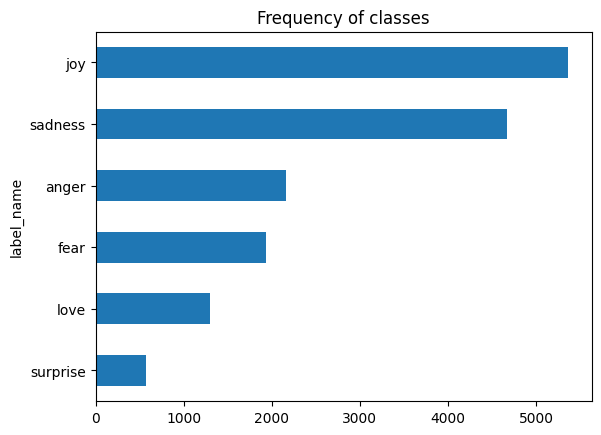

In [8]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of classes")
plt.show()

### How long are our tweets?

<Axes: title={'center': 'words per tweet'}, xlabel='label_name'>

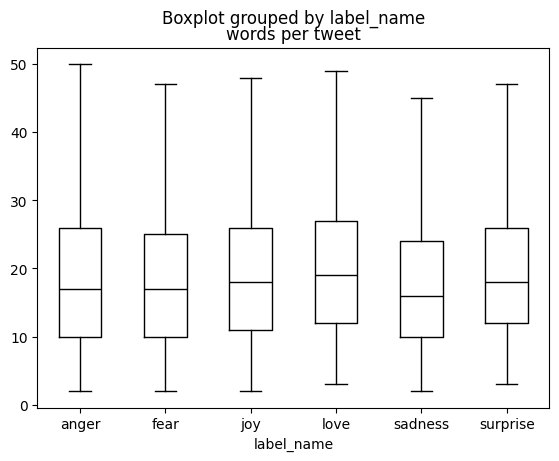

In [9]:
df["words per tweet"] = df["text"].str.split().apply(len)
df.boxplot("words per tweet", by="label_name", grid=False, showfliers=False, color="black")

We reset the format as we no longer need it

In [10]:
emotions.reset_format()

# From Text to Tokens

In [11]:
from transformers import AutoTokenizer
model = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model)

In [12]:
# We use a function to do the tokenization for us. 
# We have padding for add a padding to make  the size of each token equal. 
# Truncation is used to make the longest word a reference for other words
def tokenize(batch):
    return tokenizer(batch["text"],padding=True, truncation=True)

print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [13]:
# Now we apply the tokenizer to the whole dataset. As the batch_size is None, we will apply the tokenizer on the whole dataset all at once
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

# Training a text classifier

We use a pre-trained model, called  DistilBERT, however we cannot use this model directly to our purpose. First we need to modify it a little bit. We can have two different approaches: **Feature extraction** or **fine-tuning**

## 1. transformer as a feature extractor

In [14]:
from transformers import AutoModel
import torch
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [15]:
text = "this is a test"
inputs = tokenizer(text,return_tensors="pt")
inputs

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [16]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.inference_mode():
    outputs = model(**inputs)

print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [17]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

As we can see, the model outputs a 768 array vector as the embedded code

In [18]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}

    with torch.inference_mode():
        last_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [19]:
emotions_encoded["train"].column_names

['text', 'label', 'input_ids', 'attention_mask']

In [20]:
emotions_encoded.set_format("torch", columns=["input_ids","attention_mask","label"])

In [21]:
emotions_hidden = emotions_encoded.map(extract_hidden_states,batched=True)

In [22]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [23]:
import numpy as np
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from umap import UMAP

# Scale features
X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)

# DataFrame of embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["x", "y"])
df_emb["label"] = y_train
print(df_emb.head())


          x         y  label
0  4.322462  3.891791      0
1 -3.171566  4.924239      0
2  5.540360  7.341905      3
3 -2.243798  6.986562      2
4 -3.281827  6.928382      3


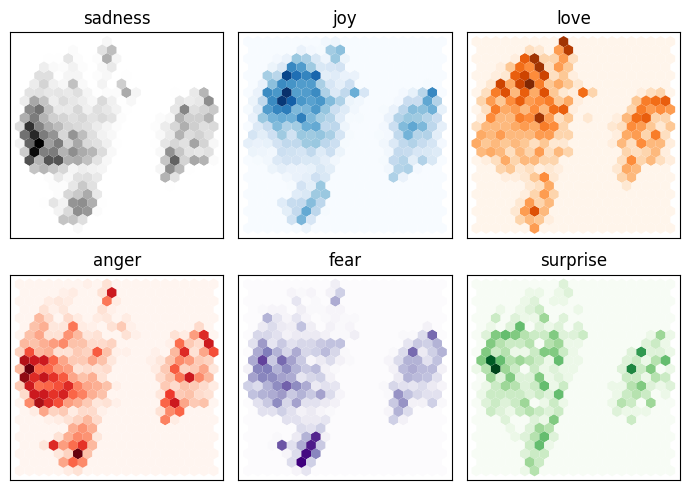

In [27]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["x"], df_emb_sub["y"], cmap=cmap,
    gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()